In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
!pwd
%cd /content/drive/MyDrive/AI/MachineLearning/Potato-Leaf-Disease-Classification/training/
!pwd

/content
/content/drive/MyDrive/AI/MachineLearning/Potato-Leaf-Disease-Classification/training
/content/drive/MyDrive/AI/MachineLearning/Potato-Leaf-Disease-Classification/training


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
classnames = dataset.class_names
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

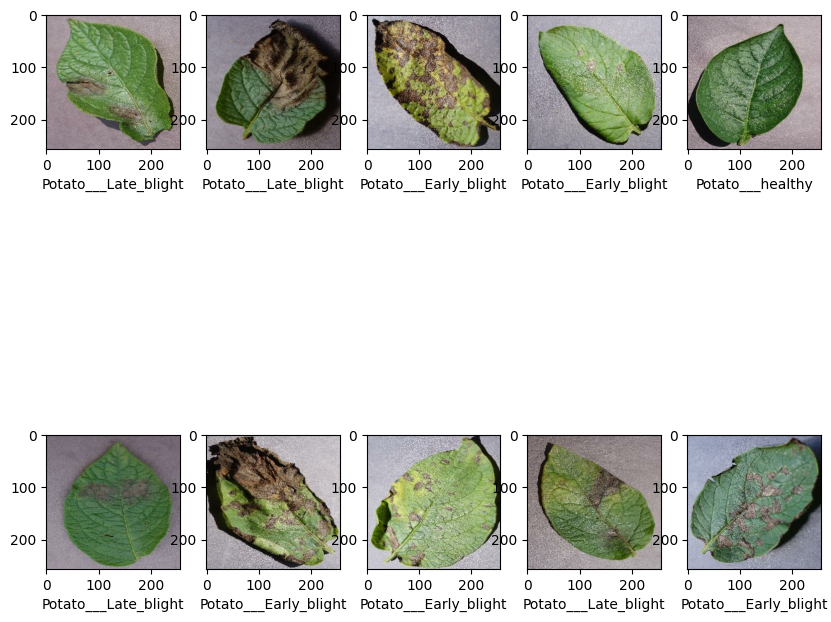

In [7]:
#exploring the data
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(10):
    #print(image_batch.shape)
    #print(label_batch.numpy())
    ax = plt.subplot(2,5,i+1)
    plt.xlabel(classnames[label_batch[i]])
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    #plt.axis("off")

In [8]:
#I need to divide the size of train and test sets as 80% and 20%(10% validation & 10% test)
train_size = 0.8
train_size * len(dataset)

54.400000000000006

In [ ]:
train_set = dataset.take(54)
len(train_set)

In [10]:
test_set = dataset.skip(54) #skips first 54 batches, each batch is of size 32
len(test_set)

14

In [11]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [12]:
#will take 6 samples of valid set
val_set = test_set.take(6)
test_set = test_set.skip(6)

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)
  train_size = (int)(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_set = dataset.take(train_size)
  val_set = dataset.skip(train_size).take(val_size)
  test_set = dataset.skip(train_size).skip(val_size)
  return train_set,val_set,test_set

In [14]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


54
6
8


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#normalizing the values
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
#normalizing the values
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

In [21]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 117s 187ms/step - loss: 0.8934 - accuracy: 0.5243 - val_loss: 0.8664 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 1s 19ms/step - loss: 0.6809 - accuracy: 0.6875 - val_loss: 0.6909 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 1s 18ms/step - loss: 0.4241 - accuracy: 0.8177 - val_loss: 0.2327 - val_accuracy: 0.9323
Epoch 4/50
54/54 [==============================] - 1s 18ms/step - loss: 0.2954 - accuracy: 0.8808 - val_loss: 0.1619 - val_accuracy: 0.9531
Epoch 5/50
54/54 [==============================] - 1s 18ms/step - loss: 0.2471 - accuracy: 0.9057 - val_loss: 0.1703 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 1s 19ms/step - loss: 0.2340 - accuracy: 0.9097 - val_loss: 0.1216 - val_accuracy: 0.9531
Epoch 7/50
54/54 [==============================] - 1s 18ms/step - loss: 0.1954 - accuracy: 0.9265 - val_loss: 0.1290 - val_accuracy: 0.9479
Epoch 8/50

In [22]:
#evaluating on test dataset
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 32ms/step - loss: 0.0623 - accuracy: 0.9784


In [23]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
#plotting various values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

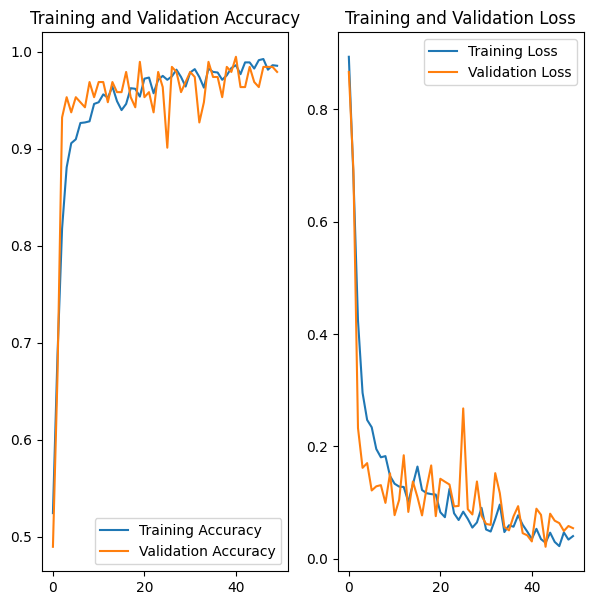

In [28]:
plt.figure(figsize=(7,7))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 146ms/step
predicted label: Potato___Late_blight


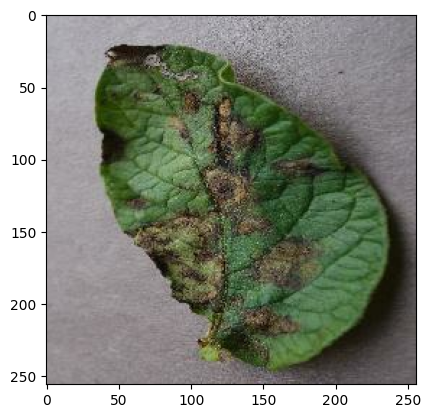

In [29]:
#checking the actual and predicted labels
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = classnames[np.argmax(batch_prediction[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = classnames[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}.")